# MT3DMS Example Problems

The purpose of this notebook is to recreate the example problems that are described in the 1999 MT3DMS report.

There are 10 example problems:

1. One-Dimensional Transport in a Uniform Flow Field
2. One-Dimensional Transport with Nonlinear or Nonequilibrium Sorption
3. Two-Dimensional Transport in a Uniform Flow Field
4. Two-Dimensional Transport in a Diagonal Flow Field
5. Two-Dimensional Transport in a Radial Flow Field
6. Concentration at an Injection/Extraction Well
7. Three-Dimensional Transport in a Uniform Flow Field
8. Two-Dimensional, Vertical Transport in a Heterogeneous Aquifer
9. Two-Dimensional Application Example
10. Three-Dimensional Field Case Study

_This notebook presents example 1_

**1. One-Dimensional Transport in a Uniform Flow Field**

In [1]:
# Import required basic packages
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy

from flopy.utils.util_array import read1d

mpl.rcParams["figure.figsize"] = (8, 8)

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.23.5
matplotlib version: 3.7.1
flopy version: 3.3.6


In [2]:
#Simulation-specific settings

# These are the names of the executables. It is assumed that these executables are available 
# through your Path-Environment. If this is not the case, you can directly link them here.
exe_name_mf = "mf2005_MT3D"
exe_name_mt = "mt3dms5b"

# This defines the path where data and results are saved
datadir = os.path.join("..", "data", "mt3d_test", "mt3dms")
workdir = os.path.join(".", "data")

## Example 1. One-Dimensional Transport in a Uniform Flow Field

MT3D can account for conservative and reactive transport. The following transport processes are considered as conservative
* Advection,
* Dispersion (incl. Diffusion).

Further, reactive transport processes are
* Sorption, and
* Decay.

The following example account for a constant release of solutes in a medium with a defined background concentration.

This example has 4 cases:
* Case 1 (A): Advection only
* Case 2 (AD): Advection and dispersion
* Case 3 (ADS): Advection, dispersion, and sorption
* Case 4 (ADSD): Advection, dispersion, sorption, and decay

**TODO: Provide figure for the situation**

Subsequently, the notebook defines a base model (named EX1_MODEL) that allows to modify the settings by changing the parameters of this model

In [3]:
# this is the base model, which will be run with different parameters in the subsequent analysis

def EX1_MODEL(dirname, al, retardation, lambda1, mixelm):
    model_ws = os.path.join(workdir, dirname)
    
    #This is the discretization in space
    nlay = 1
    nrow = 1
    ncol = 21
    delr = 50
    delc = 1
    delv = 1
    Lx = (ncol - 1) * delr
    v = 0.24
    prsity = 0.25
    q = v * prsity
    
    #This is the discretization in time
    perlen = 2000.0
    
    #This are the hydraulic parameters and properties
    hk = 1.0
    laytyp = 0
    
    #This are transport parameters
    rhob = 0.25
    kd = (retardation - 1.0) * prsity / rhob

    #This is the FloPy code to define and run the flow model
    modelname_mf = dirname + "_mf"
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf
    )
    dis = flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=0.0,
        botm=[0 - delv],
        perlen=perlen,
    )
    ibound = np.ones((nlay, nrow, ncol), dtype=int)
    ibound[0, 0, 0] = -1
    ibound[0, 0, -1] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=float)
    h1 = q * Lx
    strt[0, 0, 0] = h1
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)
    mf.write_input()
    mf.run_model(silent=True)

    #This is the FloPy code to define and run the transport model
    modelname_mt = dirname + "_mt"
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=model_ws,
        exe_name=exe_name_mt,
        modflowmodel=mf,
    )
    c0 = 1.0
    icbund = np.ones((nlay, nrow, ncol), dtype=int)
    icbund[0, 0, 0] = -1
    sconc = np.zeros((nlay, nrow, ncol), dtype=float)
    sconc[0, 0, 0] = c0
    btn = flopy.mt3d.Mt3dBtn(mt, icbund=icbund, prsity=prsity, sconc=sconc)
    dceps = 1.0e-5
    nplane = 1
    npl = 0
    nph = 4
    npmin = 0
    npmax = 8
    nlsink = nplane
    npsink = nph
    adv = flopy.mt3d.Mt3dAdv(
        mt,
        mixelm=mixelm,
        dceps=dceps,
        nplane=nplane,
        npl=npl,
        nph=nph,
        npmin=npmin,
        npmax=npmax,
        nlsink=nlsink,
        npsink=npsink,
        percel=0.5,
    )
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al)
    rct = flopy.mt3d.Mt3dRct(
        mt,
        isothm=1,
        ireact=1,
        igetsc=0,
        rhob=rhob,
        sp1=kd,
        rc1=lambda1,
        rc2=lambda1,
    )
    ssm = flopy.mt3d.Mt3dSsm(mt)
    gcg = flopy.mt3d.Mt3dGcg(mt)
    mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)
    
    #This is the post-processing to get and plot the simulation results
    fname = os.path.join(model_ws, "MT3D001.UCN")
    ucnobj = flopy.utils.UcnFile(fname)
    times = ucnobj.get_times()
    conc = ucnobj.get_alldata()

    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None

    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)

    return mf, mt, conc, cvt, mvt

### Explanation about the parameters of EX1_MODEL(_dirname, al, retardation, lambda1, mixelm_):
* dirname = folder where results will be saved
* al = Longitudinal dispersion
* retardation = delay due to sorption (no sorption -> retardation = 1)
* lambda1 = degradation constant (no degradation -> lambda1 = 0)
* mixelm = numerical solution method; following the explanation from the MT3DMS documentation

MIXELM is an integer flag for the advection solution option./
* MIXELM = 0, the standard finite-difference method with upstream or central-in-space weighting, depending on the value of NADVFD;
* =  1, the forward-tracking method of characteristics (MOC);
* =  2, the backward-tracking modified method of characteristics (MMOC);
* =  3, the hybrid method of characteristics (HMOC) with MOC or MMOC automatically and dynamically selected;
* = -1, the third-order TVD scheme (ULTIMATE).

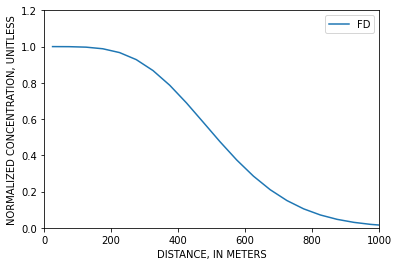

In [4]:
# The following code runs the Case1 with different settings.
# Case 1 is PURE ADVECTION! 
# The different algorithms/methods for
# transport computation can be activated with the parameter MIXELM
# (= the last one in the arguments for the model)

# HERE MIXELM = 0 -> standard Finite Difference

mf, mt, conc, cvt, mvt = EX1_MODEL("CASE1", 0, 1, 0, 0)
x = mf.modelgrid.xcellcenters.ravel()
y = conc[0, 0, 0, :]
plt.plot(x, y, label="FD")

# This is the same model but with MOC (remove the # in the first position to activate the code)

#mf, mt, conc, cvt, mvt = EX1_MODEL("CASE1", 0, 1, 0, 1)
#x = mf.modelgrid.xcellcenters.ravel()
#y = conc[0, 0, 0, :]
#plt.plot(x, y, label="MOC")

# This is the same model but with TVD (remove the # in the first position to activate the code)

#mf, mt, conc, cvt, mvt = EX1_MODEL("CASE1", 0, 1, 0, -1)
#x = mf.modelgrid.xcellcenters.ravel()
#y = conc[0, 0, 0, :]
#plt.plot(x, y, label="TVD")

plt.xlim(0, 1000)
plt.ylim(0, 1.2)
plt.xlabel("DISTANCE, IN METERS")
plt.ylabel("NORMALIZED CONCENTRATION, UNITLESS")
plt.legend()

In [ ]:
mf, mt, conc, cvt, mvt = EX1_MODEL("CASE2", 10, 1, 0, 0)
y = conc[0, 0, 0, :]
plt.plot(x, y, label="FD")

#mf, mt, conc, cvt, mvt = EX1_MODEL("CASE2", 10, 1, 0, 1)
#y = conc[0, 0, 0, :]
#plt.plot(x, y, label="MOC")

#mf, mt, conc, cvt, mvt = EX1_MODEL("CASE2", 10, 1, 0, -1)
#y = conc[0, 0, 0, :]
#plt.plot(x, y, label="TVD")

#mf, mt, conc, cvt, mvt = EX1_MODEL("CASE2", 50, 1, 0, 1)
#y = conc[0, 0, 0, :]
#plt.plot(x, y, "--", label="FD+")

plt.xlim(0, 1000)
plt.ylim(0, 1.2)
plt.xlabel("DISTANCE, IN METERS")
plt.ylabel("NORMALIZED CONCENTRATION, UNITLESS")
plt.legend()

In [ ]:
mf, mt, conc, cvt, mvt = EX1_MODEL("CASE3", 10, 1.5, 0, 0)
y = conc[0, 0, 0, :]
plt.plot(x, y, label="FD")

#mf, mt, conc, cvt, mvt = EX1_MODEL("CASE3", 10, 1.5, 0, 1)
#y = conc[0, 0, 0, :]
#plt.plot(x, y, label="MOC")

#mf, mt, conc, cvt, mvt = EX1_MODEL("CASE3", 10, 1.5, 0, -1)
#y = conc[0, 0, 0, :]
#plt.plot(x, y, label="TVD")

#mf, mt, conc, cvt, mvt = EX1_MODEL("CASE3", 10, 2, 0, 0)
#y = conc[0, 0, 0, :]
#plt.plot(x, y, label="FD+")

plt.xlim(0, 1000)
plt.ylim(0, 1.2)
plt.xlabel("DISTANCE, IN METERS")
plt.ylabel("NORMALIZED CONCENTRATION, UNITLESS")
plt.legend()